In [19]:
import random
import math
import copy
import time
import pandas as pd

# Funkcja zwracająca koszt dla danego rozwiązania
def oblicz_koszt(rozwiazanie, odleglosc):
    # Zwracamy sumę odległości między kolejnymi miastami w rozwiązaniu
    koszt = 0
    for i in range(len(rozwiazanie) - 1):
        koszt += odleglosc[rozwiazanie[i]][rozwiazanie[i + 1]]
    # Dodajemy koszt drogi powrotnej do pierwszego miasta
    koszt += odleglosc[rozwiazanie[-1]][rozwiazanie[0]]
    return koszt

# Funkcja generująca słownik funkcji określającej
# Prawdopodobieństwo przyjęcia kandydata
# Słownik ma postać {funkcja: lista_parametrów}
def metropolis_probability(delta_e, temperature, prob_parameter=None):
    return min(1, math.exp(-delta_e / temperature))

def boltzmann_probability(delta_e, temperature, prob_parameter=None):
        return math.exp(-delta_e / temperature)

def gaussian_probability(delta_e, temperature, prob_parameter=3): # z sigmami chyba można mocno kombinować
    return math.exp(-(delta_e ** 2) / (2 * (prob_parameter ** 2) * temperature))

def exponential_decrease_probability(delta_e, temperature, prob_parameter=1): #alpha
        return math.exp(-prob_parameter * delta_e / temperature)


def power_law_probability(delta_e, temperature, prob_parameter): # decay_factor raczej jakiś taki okolo 2
        return 1 / ((delta_e + 1) ** prob_parameter * temperature)
def prob_functions_dict():



    

    
    # def sigmoid_probability(delta_e, temperature, prob_parameter):
    #     return 1 / (1 + math.exp(-prob_parameter * delta_e / temperature)) #sigmoid

   

    

    decay_factors = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6]

    sigma_factors = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3]

    alpha_factors = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    # sigmoid_parameters = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    return {metropolis_probability: [None], boltzmann_probability: [None],
            exponential_decrease_probability: alpha_factors,
            gaussian_probability: sigma_factors, power_law_probability: decay_factors}

# Funkcja generująca słownik funkcji określającej
# Zmianę temperatury wraz z działaniem algorytmu
# Słownik ma postać {funkcja: lista_parametrów}
def t_decrease_functions_dict():



    # def exponential_cooling(T_init, T, iteration, cool_parameter):  # około 0.05
    #     return T_init * math.exp(-cool_parameter * iteration)

    linear_parameters = [0.9999, 0.99999, 0.999999, 0.9999999]

    #exp_parameters = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

    return {
        #exponential_cooling: exp_parameters,
        linear_decrease: linear_parameters
            }

# Funkcja czytająca format .atsp
# Zwraca macierz sąsiedztwa
def read_atsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

        # Extract the dimension of the problem
        for line in lines:
            if line.startswith('DIMENSION'):
                n = int(line.strip().split()[1])
                break

        # Extract the matrix
        matrix = []
        row = []
        start_reading = False
        for line in lines:
            if line.startswith('EDGE_WEIGHT_SECTION'):
                start_reading = True
                continue
            if start_reading:
                lista_liczb = list(map(int, line.strip().split()))
                for i in lista_liczb:
                    row.append(i)
                    if len(row) == n:
                        matrix.append(row)
                        row = []
                if len(matrix) == n:
                    break
        for i in range(len(matrix)):
            matrix[i][i]= 1000000

    return matrix

def simulated_annealing(T_init, T_function, cool_parameter,
                        Prob_function, prob_parameter,
                        break_point, file_name):
    start = time.time()

    odleglosc = read_atsp_file(file_name)
    miasta = [i for i in range(len(odleglosc))]

    liczba_iteracji = 1000000  # liczba iteracji

    # Losujemy początkowe rozwiązanie
    S = random.sample(range(len(miasta)), len(miasta))

    # Pętla główna algorytmu
    C1, C2 = 0, 0
    T = T_init

    global_min = float('inf')
    global_min_path = []

    for i in range(liczba_iteracji):

        # Losujemy dwa miasta i zamieniamy je miejscami
        S_p = S.copy()
        a = random.randint(0, len(S_p) - 1)
        b = random.randint(0, len(S_p) - 1)
        S_p[a], S_p[b] = S_p[b], S_p[a]

        # Obliczamy koszty dla obu rozwiązań
        C1 = oblicz_koszt(S, odleglosc)
        C2 = oblicz_koszt(S_p, odleglosc)

        # Sprawdzamy czy akceptujemy nowe rozwiązanie
        if C2 < C1:
            S = S_p
        else:
            delta_e = abs(C1-C2)
            p = Prob_function(delta_e, T, prob_parameter)
            if random.random() < p:
                S = S_p

        if i % 10000 == 0:
            print(min(C1, C2))


            print(T)

        # Zmniejszamy temperaturę
        T = T_function(T_init, T, i, cool_parameter)
        if T < break_point:
            break
        if oblicz_koszt(S, odleglosc) < global_min:
            global_min_path = [miasta[i] for i in S]
            global_min = oblicz_koszt(S, odleglosc)

    # Zwracamy najlepsze znalezione rozwiązanie
    najlepsze_rozwiazanie = [miasta[i] for i in S]
    end = time.time()

    return global_min_path, global_min, end - start
    # Sciezka, koszt, czas

def linear_decrease(Top_T, T, iteration, cool_parameter):
    return T * cool_parameter

def main():

    prob_dict = []
    temp_dict = t_decrease_functions_dict()

    starting_temperatures = [50000]  # Lista temperatur początkowych

    file_names = ['data/ftv33.atsp']  # Lista nazw plików

    min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

    df = pd.DataFrame(columns=['file_name', 'prob_function', 'prob_parameter', 'temp_function',
                               'cool_parameter', 'T_init', 'function_result', 'time', 'path'])

    # for file_name in file_names:
    #     for prob_function in prob_dict:
    #         for prob_parameter in prob_dict[prob_function]:
    #             for temp_function in temp_dict:
    #                 for cool_parameter in temp_dict[temp_function]:
    #                     for T_init in starting_temperatures:
    #
    #                         # Append the row to the DataFrame
    #
    #                         path,function_result,time = simulated_annealing(T_init=T_init, T_function=temp_function, cool_parameter=cool_parameter,
    #                                             Prob_function=prob_function, prob_parameter=prob_parameter,
    #                                             break_point=min_temperature, file_name=file_name)
    #                         row = {'file_name': file_name,
    #                                'prob_function': prob_function.__name__,
    #                                'prob_parameter': prob_parameter,
    #                                'temp_function': temp_function.__name__,
    #                                'cool_parameter': cool_parameter,
    #                                'T_init': T_init,
    #                                'function_result': function_result,
    #                                'time': time,
    #                                'path': path}
    #                         df = df.append(row, ignore_index=True)







    

In [5]:
slowniczek={}
starting_temperatures = [50000]  # Lista temperatur początkowych

file_names = ['data/ftv33.atsp']  # Lista nazw plików

min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

linear_parameters = [0.999, 0.9999, 0.99999]
slowniczek= {k: [] for k in linear_parameters}
for parametr in linear_parameters:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                            cool_parameter=parametr,
                                                            Prob_function=metropolis_probability, prob_parameter=None,
                                                            break_point=min_temperature, file_name='data/ftv33.atsp')
        slowniczek[parametr].append(function_result)


print(slowniczek)


4364
30000
1689
1.355200379311442
4564
30000
1437
1.355200379311442
4881
30000
1716
1.355200379311442
4037
30000
1627
1.355200379311442
4466
30000
1508
1.355200379311442
3986
30000
1629
1.355200379311442
4657
30000
1723
1.355200379311442
4328
30000
1812
1.355200379311442
3723
30000
1730
1.355200379311442
4422
30000
1693
1.355200379311442
4618
30000
3803
11035.831392989121
4204
4059.652484482816
4419
1493.3880110960613
3591
549.359276492254
4054
202.08787831809946
3700
74.34025838951453
1948
27.346885243264293
1484
10.059853822269574
1455
3.700628354022838
1455
1.361317018770361
1451
0.5007755030518772
1451
0.1842158005806604
4358
30000
4058
11035.831392989121
4284
4059.652484482816
4323
1493.3880110960613
4364
549.359276492254
3448
202.08787831809946
3690
74.34025838951453
2158
27.346885243264293
1444
10.059853822269574
1412
3.700628354022838
1412
1.361317018770361
1412
0.5007755030518772
1412
0.1842158005806604
5080
30000
4245
11035.831392989121
4421
4059.652484482816
4272
1493.388011

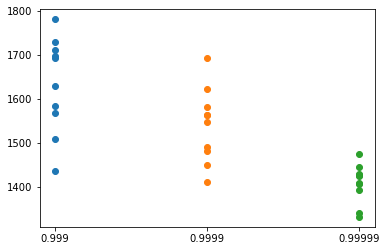

In [10]:
import matplotlib.pyplot as plt



for param in linear_parameters:
    plt.scatter([str(param)]*len(slowniczek[param]), slowniczek[param], label=param)


In [16]:
slowniczek={}
starting_temperatures = [50000, 30000, 15000, 5000]  # Lista temperatur początkowych

file_names = ['data/ftv33.atsp']  # Lista nazw plików

min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

linear_parameters = [0.99999]
slowniczek= {k: [] for k in starting_temperatures}
for temp in starting_temperatures:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=temp, T_function=linear_decrease,
                                                            cool_parameter=0.9999,
                                                            Prob_function=metropolis_probability, prob_parameter=None,
                                                            break_point=min_temperature, file_name='data/ftv33.atsp')
        slowniczek[temp].append(function_result)


print(slowniczek)


4433
50000
4225
18393.052321648454
4499
6766.087474138006
4462
2488.9800184933997
4005
915.5987941537378
4288
336.81313053015924
3560
123.90043064918837
2822
45.57814207210601
1834
16.766423037115537
1458
6.167713923371165
1426
2.2688616979505327
1426
0.8346258384197693
1426
0.3070263343010911
1426
0.11294302861847831
4334
50000
4292
18393.052321648454
4393
6766.087474138006
4020
2488.9800184933997
4273
915.5987941537378
4104
336.81313053015924
3922
123.90043064918837
3046
45.57814207210601
1696
16.766423037115537
1614
6.167713923371165
1583
2.2688616979505327
1581
0.8346258384197693
1581
0.3070263343010911
1581
0.11294302861847831
4466
50000
4552
18393.052321648454
4580
6766.087474138006
4661
2488.9800184933997
4293
915.5987941537378
4446
336.81313053015924
3631
123.90043064918837
2902
45.57814207210601
1743
16.766423037115537
1580
6.167713923371165
1580
2.2688616979505327
1580
0.8346258384197693
1580
0.3070263343010911
1580
0.11294302861847831
4545
50000
4371
18393.052321648454
4344


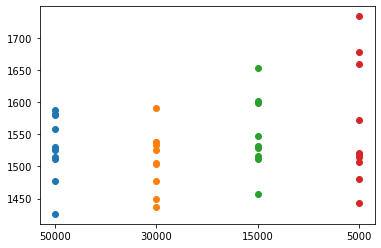

In [17]:

for temp in starting_temperatures:
    plt.scatter([str(temp)]*len(slowniczek[temp]), slowniczek[temp], label=temp)

In [24]:
slowniczek2={}
starting_temperatures = [50000]  # Lista temperatur początkowych

file_names = ['data/ftv33.atsp']  # Lista nazw plików
parametry=[None, None,1, 3, 2 ]
min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu
prob_functions=[metropolis_probability, boltzmann_probability, exponential_decrease_probability, gaussian_probability,power_law_probability]
linear_parameters = [0.99999]
slowniczek2= {k: [] for k in prob_functions}
i=0
for fun in prob_functions:
    prob_parameter=parametry[i]
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=50000, T_function=linear_decrease,
                                                            cool_parameter=0.9999,
                                                            Prob_function=fun, prob_parameter=parametry[i],
                                                            break_point=min_temperature, file_name='data/ftv33.atsp')
        slowniczek2[fun].append(function_result)
    i+=1


print(slowniczek2)

4957
50000
4367
18393.052321648454
4161
6766.087474138006
4493
2488.9800184933997
4068
915.5987941537378
3948
336.81313053015924
3415
123.90043064918837
2835
45.57814207210601
1639
16.766423037115537
1539
6.167713923371165
1540
2.2688616979505327
1540
0.8346258384197693
1539
0.3070263343010911
1539
0.11294302861847831
4151
50000
4784
18393.052321648454
4408
6766.087474138006
4225
2488.9800184933997
3898
915.5987941537378
4351
336.81313053015924
4274
123.90043064918837
3268
45.57814207210601
1737
16.766423037115537
1456
6.167713923371165
1442
2.2688616979505327
1441
0.8346258384197693
1441
0.3070263343010911
1441
0.11294302861847831
4222
50000
4166
18393.052321648454
3838
6766.087474138006
4256
2488.9800184933997
4805
915.5987941537378
3986
336.81313053015924
3751
123.90043064918837
2851
45.57814207210601
1608
16.766423037115537
1470
6.167713923371165
1470
2.2688616979505327
1469
0.8346258384197693
1469
0.3070263343010911
1469
0.11294302861847831
4296
50000
4665
18393.052321648454
3818


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

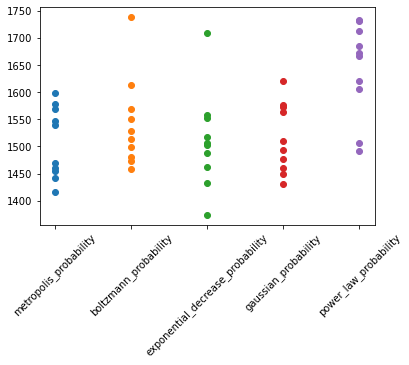

In [31]:

for fun in prob_functions:
    plt.scatter([str(fun.__name__)]*len(slowniczek2[fun]), slowniczek2[fun], label=fun)
plt.xticks(rotation=45)
